In [1]:
%matplotlib inline
import numpy as np
import numpy.ma as ma
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import line_profiler

import datetime

from io import StringIO
from pandas.api.types import CategoricalDtype

import pandas._testing as tm

## returns df from string data
def g(data):
    return pd.read_csv(StringIO(data))

In [258]:
df = pd.DataFrame({'ClubID':[1, 2, 3, 1, 1],
                  'PlayerID':[1, 1, 1, 2, 2],
                  'FromDate':["2010-01-01", "2012-02-01", "2015-05-01", "2010-01-01", "2018-03-02"],
                  'ToDate':["2012-01-01", "2015-02-01", "2018-02-01", "2018-02-02", "2020-02-01"],
                  'TeamName':["Club A", "Club B", "Club C",  "Club A", "Club A"],
                  'c_Person':["Player 1", "Player 1", "Player 1", "Player 2", "Player 2"]})

# convert the 'Date' columns to datetime format
df['FromDate']= pd.to_datetime(df['FromDate'])
df['ToDate']= pd.to_datetime(df['ToDate'])
df

,ClubID,PlayerID,FromDate,ToDate,TeamName,c_Person
0,1,1,2010-01-01,2012-01-01,Club A,Player 1
1,2,1,2012-02-01,2015-02-01,Club B,Player 1
2,3,1,2015-05-01,2018-02-01,Club C,Player 1
3,1,2,2010-01-01,2018-02-02,Club A,Player 2
4,1,2,2018-03-02,2020-02-01,Club A,Player 2


In [278]:
d="""X,Y
abc,def
ghi,jkl"""
df_A=g(d)
df_A

,X,Y
0,abc,def
1,ghi,jkl


In [279]:
d="""X,Y
mno,pqr
stu,vwx
zya,bcd"""
df_B = g(d)
df_B

,X,Y
0,mno,pqr
1,stu,vwx
2,zya,bcd


In [285]:
d="""Task,ID,Value,Sno
A,A1,5,1
A,A1,2,2
B,A1,4,3
A,A1,1,4
A,B1,10,5
C,B1,3,6
D,B1,5,7
D,B1,2,8
D,B1,12,9
E,C1,25,10"""
df=g(d)
df

,Task,ID,Value,Sno
0,A,A1,5,1
1,A,A1,2,2
2,B,A1,4,3
3,A,A1,1,4
4,A,B1,10,5
5,C,B1,3,6
6,D,B1,5,7
7,D,B1,2,8
8,D,B1,12,9
9,E,C1,25,10


In [286]:
df.groupby(['Task','ID']).agg({'Value':'sum', 'Sno':list})

Value        Sno
Task ID                  
A    A1      8  [1, 2, 4]
     B1     10        [5]
B    A1      4        [3]
C    B1      3        [6]
D    B1     19  [7, 8, 9]
E    C1     25       [10]

<AxesSubplot:ylabel='name'>

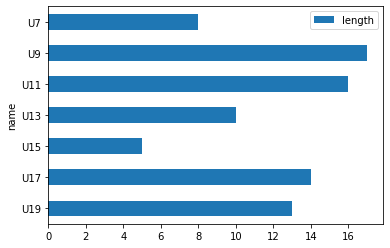

In [296]:
d="""name,length
U19,13
U17,14
U15,5
U13,10
U11,16
U9,17
U7,8"""
df=pd.read_csv(StringIO(d))
df = df.set_index('name')
df

df.plot.barh()

<AxesSubplot:ylabel='name'>

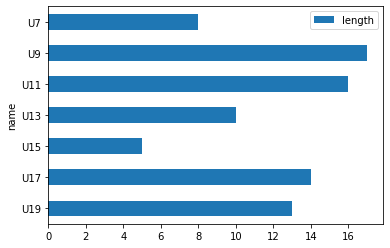

In [316]:
d="""timestamp,open,high,low,close
2021-05-14 15:25:00+05:30,751.70,752.10,750.5,751.55
2021-05-14 15:26:00+05:30,751.55,751.95,750.5,751.00
2021-05-14 15:27:00+05:30,751.00,751.50,750.0,750.30
2021-05-14 15:28:00+05:30,751.00,751.80,750.0,751.50
2021-05-14 15:29:00+05:30,751.50,755.00,751.0,755.00"""
df=g(d)
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')
df = df.reset_index()
df = df.rename(columns = {'timestamp':'time'})
df

,time,open,high,low,close
0,2021-05-14 15:25:00+05:30,751.70,752.10,750.5,751.55
1,2021-05-14 15:26:00+05:30,751.55,751.95,750.5,751.00
2,2021-05-14 15:27:00+05:30,751.00,751.50,750.0,750.30
3,2021-05-14 15:28:00+05:30,751.00,751.80,750.0,751.50
4,2021-05-14 15:29:00+05:30,751.50,755.00,751.0,755.00


In [315]:
import json
json.dumps(json.loads(df.to_json(orient='index')))

'{"0": {"time": 1620986100000, "open": 751.7, "high": 752.1, "low": 750.5, "close": 751.55}, "1": {"time": 1620986160000, "open": 751.55, "high": 751.95, "low": 750.5, "close": 751.0}, "2": {"time": 1620986220000, "open": 751.0, "high": 751.5, "low": 750.0, "close": 750.3}, "3": {"time": 1620986280000, "open": 751.0, "high": 751.8, "low": 750.0, "close": 751.5}, "4": {"time": 1620986340000, "open": 751.5, "high": 755.0, "low": 751.0, "close": 755.0}}'

In [13]:
df = pd.DataFrame({
    'ticker':['GOOG','AMZN','AMZN','GOOG'],
    'date':['2020.02.01', '2020.01.03', '2020.02.01','2020.01.01' ],
    'Research and Development Expense Lag':[100,200,300,400],
    'Capital Expenditures Lag':[10,20,30,40]
})
df.date = pd.to_datetime(df.date)
df

,ticker,date,Research and Development Expense Lag,Capital Expenditures Lag
0,GOOG,2020-02-01,100,10
1,AMZN,2020-01-03,200,20
2,AMZN,2020-02-01,300,30
3,GOOG,2020-01-01,400,40


In [19]:
def coco_convert(country):
    return 'awesome ' + country 

df = pd.DataFrame({
    'Country':['ab', 'bc']
})

df['alpha-3'] = df.Country.apply(coco_convert)
df

,Country,alpha-3
0,ab,awesome ab
1,bc,awesome bc


In [44]:
class test1:

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def mult(self):
    
        return self.x*self.y


data = {'x': [3, 2, 1, 0], 'y': [5, 6, 1, 2]}
fpd = pd.DataFrame.from_dict(data)
fpd

,x,y
0,3,5
1,2,6
2,1,1
3,0,2


In [45]:
fpd['class'] = test1(fpd['x'], fpd['y'])
fpd['method'] = fpd['class'].apply(lambda x: x.mult()).iloc[0]
fpd

,x,y,class,method
0,3,5,<__main__.test1 object at 0x1205bd3a0>,15
1,2,6,<__main__.test1 object at 0x1205bd3a0>,12
2,1,1,<__main__.test1 object at 0x1205bd3a0>,1
3,0,2,<__main__.test1 object at 0x1205bd3a0>,0


In [50]:
fpd['class'].apply(lambda x:x.mult())

,0,1,2,3
0,15,12,1,0
1,15,12,1,0
2,15,12,1,0
3,15,12,1,0


In [58]:
rng = pd.date_range('2015-02-24', periods=5, freq='M')
df = pd.DataFrame({ 'Date': rng, 'ID': ['ABD','ABD','CDE','CDE','FEK'] }) 
df

,Date,ID
0,2015-02-28,ABD
1,2015-03-31,ABD
2,2015-04-30,CDE
3,2015-05-31,CDE
4,2015-06-30,FEK


In [59]:
df = df[~df.index.isin([1,3])].reset_index(drop=True)
df

,Date,ID
0,2015-02-28,ABD
1,2015-04-30,CDE
2,2015-06-30,FEK


In [60]:
data = [["2020-01-01", "2020-01-01"], ["2020-01-02", "2020-01-04"], ["2020-01-05", "2020-01-06"]]
df = pd.DataFrame(data, columns=["START", "END"]).astype({"END": "datetime64[ns]" , "START": "datetime64[ns]"})
df

,START,END
0,2020-01-01,2020-01-01
1,2020-01-02,2020-01-04
2,2020-01-05,2020-01-06


In [62]:
timestamps = pd.Series(["2020-01-02", "2020-01-03"], dtype="datetime64[ns]")

In [71]:
def t():
    t = timestamps.values
    return ((df['START'].values[:, None] <= t) & (df['END'].values[:, None] >= t)).any(1)

In [68]:
def test():
    s = pd.IntervalIndex.from_arrays(df['START'], 
                                 df['END'], 
                                 closed='both')

    i = pd.Interval(timestamps.min(), timestamps.max(), closed='both')
    return s.overlaps(i)


817 µs ± 70.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [69]:
%timeit test()

791 µs ± 32.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [72]:
%timeit t()

20.4 µs ± 1.16 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [75]:
d = {'date': [1, 1, 1, 2, 2], 'mass': [3, 40, 10, 12, 15], '%': [0.4, 0.7, 0.9, 0.1, 0.2]}
df = pd.DataFrame(data=d)
df = df.set_index('date')

df['w'] = df.mass * df['%']
df

,mass,%,w
date,,,
1,3,0.4,1.2
1,40,0.7,28.0
1,10,0.9,9.0
2,12,0.1,1.2
2,15,0.2,3.0


In [80]:
(df.groupby('date').w.sum()) / df.groupby('date').mass.count()

date
1    12.733333
2     2.100000
dtype: float64

In [2]:
raw_data = {'Event': ['A','B','C','D', 'E'],
            'dates': ['08-12-1600','26-09-1400', '04-11-1991','25-03-1991', '10-05-1991']}
df_1 = pd.DataFrame(raw_data, columns = ['Event', 'dates'])


def conv(x):
    day,month,year = tuple(x.split('-'))
    return pd.Period(year=int(year), month=int(month), day=int(day), freq="D")

df_1['dates'] = df_1.dates.apply(conv)
df_1

,Event,dates
0,A,1600-12-08
1,B,1400-09-26
2,C,1991-11-04
3,D,1991-03-25
4,E,1991-05-10


In [105]:
raw_data = {'Event': ['A','B','C','D', 'E'],
            'dates': ['08-12-1600','26-09-1400', '04-11-1991','25-03-1991', '10-05-1991']}
df_1 = pd.DataFrame(raw_data, columns = ['Event', 'dates'])
df_1['dates'] = pd.to_datetime(df_1.dates, errors='coerce')
df_1

,Event,dates
0,A,NaT
1,B,NaT
2,C,1991-04-11
3,D,1991-03-25
4,E,1991-10-05


In [82]:
times = [
    '2021-02-18',
    '2021-02-22',
    '2021-02-23',
    '2021-04-23',
    '2021-01-18',
    '2021-01-19',
    '2021-01-20',
    '2021-01-03',
    '2021-02-04',
    '2021-02-04'
] 

id = [1, 1, 1, 1, 44, 44, 44, 46, 46, 46]

df = pd.DataFrame({'ID':id, 'Date': pd.to_datetime(times)})

df = df.reset_index(drop=True)
df
df['Date'] = pd.to_datetime(df.Date)
df = df.set_index('Date')
#ind = pd.period_range(start=df.Date.min(), 
 #               end=df.Date.max(), freq='M').strftime('%m_%Y')

In [52]:
df.pivot_table(
        index='ID',
        columns=df['Date'].dt.strftime('%m_%Y'),
        aggfunc='size'
    )

Date,01_2021,02_2021,04_2021
ID,,,
1,NaN,3.0,1.0
44,3.0,NaN,NaN
46,1.0,2.0,NaN


In [12]:
from pandas import Period
df1 = pd.DataFrame(
{'YearMonth': {0: Period('2020-07', 'M'), 1: Period('2020-06', 'M')},
 'State': {0: 'BBB', 1: 'AAA'}}
)
df1

,YearMonth,State
0,2020-07,BBB
1,2020-06,AAA


In [61]:
cols = pd.MultiIndex.from_arrays([np.repeat(['price', 'cost'], 3), 
                           np.repeat(['mean', 'max', 'min'], 2)])
df = pd.DataFrame([[1,1,1,1,2,3],[2,2,2,1,2,3],[3,3,3,1,2,3]],
                 columns=cols )
df

price          cost        
   mean mean max  max min min
0     1    1   1    1   2   3
1     2    2   2    1   2   3
2     3    3   3    1   2   3

In [67]:
df.rename_axis(['type',None],axis=1).stack(0).reset_index().sort_values('type')

,level_0,type,max,mean,min
0,0,cost,1,1,2
2,1,cost,1,2,2
4,2,cost,1,3,2
1,0,price,1,1,3
3,1,price,2,2,3
5,2,price,3,3,3


In [71]:
df = pd.DataFrame({'a':[1,2,1,1,3,4,2,3,4,1]})
df['bin'] = pd.cut(df.a, bins=[0,2,4,6])
df

,a,bin
0,1,"(0, 2]"
1,2,"(0, 2]"
2,1,"(0, 2]"
3,1,"(0, 2]"
4,3,"(2, 4]"
5,4,"(2, 4]"
6,2,"(0, 2]"
7,3,"(2, 4]"
8,4,"(2, 4]"
9,1,"(0, 2]"
